# Deep learning in genomics

This notebook is based on the [jupyter notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [6]:
# fastai version
__version__

'1.0.36.post1'

# Data setup

## Load data from the web, generate dataframe, and save to disk

In [5]:
import requests

In [6]:
URL_seq = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

In [7]:
# get data from URL
seq_raw = requests.get(URL_seq).text.split('\n')
seq_raw = list(filter(None, seq_raw)) # Removes empty lists

In [8]:
# check length
len(seq_raw)

2000

In [9]:
# setup df from list
seq_df = pd.DataFrame(seq_raw, columns=['Sequences'])

In [10]:
# show head of dataframe
#seq_df.head()

In [11]:
URL_labels = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

In [12]:
seq_labels = requests.get(URL_labels).text.split('\n')
seq_labels = list(filter(None, seq_labels)) # Removes empty entries

In [13]:
len(seq_labels)

2000

In [14]:
seq_label_series = pd.Series(seq_labels)

In [15]:
seq_df['Target'] = seq_label_series.astype('int')

In [16]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [67]:
seq_df.to_csv('seq_df.csv')

## Data frame setup

In [7]:
seq_df = pd.read_csv('seq_df.csv', index_col=0)

In [58]:
seq_df.head()

,Sequences,Target,MultiTarget
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0,0;1
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0,0;1
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0,0;1
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1,1;0
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1,1;0


### Target setup

In [164]:
targA = seq_df['Target'].values.astype(int); targA

array([0, 0, 0, 1, ..., 1, 0, 1, 1])

In [165]:
targB = np.logical_not(seq_df['Target'].values).astype(int); targB

array([1, 1, 1, 0, ..., 0, 1, 0, 0])

In [166]:
targ = [[a,b] for a, b in zip(targA, targB)]; targ[:4], '...', targ[-4:]#, len(targ)

([[0, 1], [0, 1], [0, 1], [1, 0]], '...', [[1, 0], [0, 1], [1, 0], [1, 0]])

### Preprocessing for MultiTarget (only needed for fastai training)

In [231]:
seq_df['MultiTarget'] = targ

In [232]:
def joinarray(x):
    y = ';'.join((str(x[0]),str(x[1])))
    return y

In [233]:
seq_df['MultiTarget'] = seq_df['MultiTarget'].apply(joinarray)

In [234]:
seq_df.head()

,Sequences,Target,MultiTarget
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0,0;1
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0,0;1
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0,0;1
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1,1;0
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1,1;0


## fastai data object

### Setup custom fastai data object

In [18]:
# open sequence image function
def open_seq_image(seq:str, cls:type=Image)->Image:
    "Return `Image` object created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    #print('enc', enc, enc.shape)
    
    # https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
    x = PIL.Image.fromarray(enc.astype('uint8')).convert('P')
    x = pil2tensor(x,np.float32)
    #x = x.view(4,-1) # remove first dimension
    #x = x.expand(3, 4, 50) # expand to 3 channel image
    #print('x', x, x.shape)
    return cls(x)

In [19]:
# test open sequence image function
open_seq_image('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC')

In [20]:
class SeqItemList(ImageItemList):
    _bunch,_square_show = ImageDataBunch,True
    def __post_init__(self):
        super().__post_init__()
        self.sizes={}
    
    def open(self, seq): return open_seq_image(seq)
    
    def get(self, i):
        seq = self.items[i][0]
        res = self.open(seq)
        return res
    
    @classmethod
    def import_from_df(cls, df:DataFrame, cols:IntsOrStrs=0, **kwargs)->'ItemList':
        "Get the sequences in `col` of `df` and will had `path/folder` in front of them, `suffix` at the end."
        return cls(items=df[cols].values)

In [21]:
bs = 64

In [274]:
data = (SeqItemList.import_from_df(seq_df, ['Sequences'])
        .random_split_by_pct(valid_pct=0.25)
        #.split_by_idxs(range(1500), range(1500,2000))
        #.label_from_list(seq_df['Target'].values) # --> Two categories! AND WRONG LOSS FUNCTION!?
        #.label_from_list(targ) # --> MultiCategory
        #.label_from_list(seq_df['MultiTarget'], sep=';')
        #.label_from_list(seq_df['Target'].values, sep=';')
        #.label_from_list(targ)
        .label_from_list(targA)
        .databunch(bs=bs))

### Verify data object

#### Check data object

In [275]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (2000 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: .
x: SeqItemList (1500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;

Valid: LabelList
y: CategoryList (2000 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: .
x: SeqItemList (500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;

Test: None

In [276]:
# check classes
data.c, data.classes

(2, [0, 1])

In [277]:
data.train_dl.batch_size

64

In [278]:
# show array data of one batch
#next(iter(data.train_dl))

#### Check data points

In [279]:
i = 2
data.x[i]

In [280]:
data.y[i]

Category 0

In [281]:
i = 3
data.x[i]

In [282]:
data.y[i]

Category 1

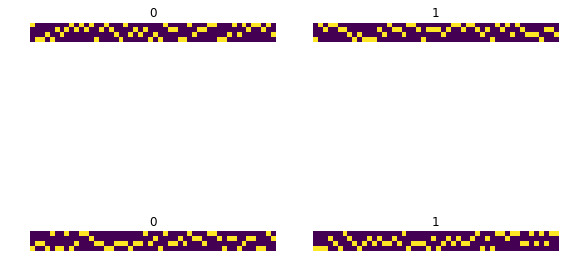

In [283]:
data.show_batch(rows=2)

# Model setup

## Basic model for fastai training

In [284]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [285]:
def ResizeInput(): return Lambda(lambda x: x.view((-1,)+x.size()[-2:]))

In [286]:
drop_p = 0.2

In [314]:
net_basic_fastai = nn.Sequential(ResizeInput(),
                    nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=16, out_features=2),
                    #nn.Dropout(drop_p), # not at the end?
                    #Debugger()
                   )

In [315]:
net_basic_fastai

Sequential(
  (0): Lambda()
  (1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Lambda()
  (4): Dropout(p=0.2)
  (5): Linear(in_features=288, out_features=16, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.2)
  (8): Linear(in_features=16, out_features=2, bias=True)
)

In [316]:
# initialize weights with kaiming normal initialization
apply_init(net_basic_fastai, nn.init.kaiming_normal_)

# Model training

## Train basic model with fastai

In [328]:
torch.tensor([[0.2,0.8],[0.7,0.3]]).argmax(dim=-1)

tensor([1, 0])

In [336]:
import pdb

def accuracy(input:Tensor, targs:LongTensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    pdb.set_trace()
    return (input==targs).float().mean()

In [337]:
learn = Learner(data, net_basic_fastai, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)#_thresh)

In [318]:
#learn.summary()

In [319]:
#learn.lr_find()
#learn.recorder.plot()

In [338]:
learn.fit(10, lr=1e-3)

epoch,train_loss,valid_loss,accuracy


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a2975a9e8>>
Traceback (most recent call last):
  File "/Users/MMP/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 412, in __del__
    self._shutdown_workers()
  File "/Users/MMP/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 406, in _shutdown_workers
    w.join()
  File "/Users/MMP/anaconda3/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a2975a9e8>>
Traceback (most recent call last):
  File "/Users/MMP/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 412, in __del__
    self._shutdown_workers()
  File "/Users/MMP/anaconda3/lib/pytho

> <ipython-input-336-b2e43befb475>(9)accuracy()
-> return (input==targs).float().mean()
(Pdb) input.shape
torch.Size([64, 1])
(Pdb) targs.shape
torch.Size([64, 1])
(Pdb) input
tensor([[0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
     

BdbQuit: 

In [ ]:
%debug

In [230]:
# Expected object of scalar type Long but got scalar type Float for argument #2 'target'

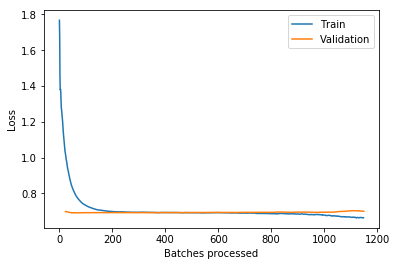

In [33]:
learn.recorder.plot_losses()

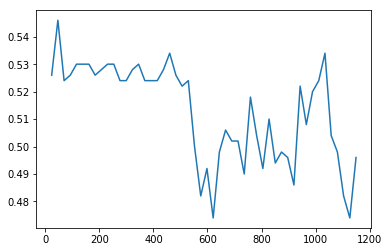

In [34]:
learn.recorder.plot_metrics()

In [35]:
learn.get_preds(DatasetType.Train)

[tensor([[0.4405, 0.5595],
         [0.5427, 0.4573],
         [0.6023, 0.3977],
         ...,
         [0.4940, 0.5060],
         [0.5718, 0.4282],
         [0.4605, 0.5395]]), tensor([1, 1, 1,  ..., 1, 0, 1])]

In [36]:
data.train_ds[0][1], data.train_ds[3][1]

(Category 0, Category 1)

In [37]:
#net(data.train_ds[0][0].data), net(data.train_ds[3][0].data)

In [39]:
learn.model(data.train_ds[0][0].data), learn.model(data.train_ds[3][0].data)

(tensor([[-0.0752, -0.4870]], grad_fn=<ThAddmmBackward>),
 tensor([[-0.0573, -0.0583]], grad_fn=<ThAddmmBackward>))

In [42]:
torch.sigmoid(learn.model(data.train_ds[0][0].data)).detach().numpy()#>0.5

array([[0.481204, 0.380592]], dtype=float32)

In [43]:
torch.sigmoid(learn.model(data.train_ds[3][0].data)).detach().numpy()#>0.5

array([[0.485679, 0.485433]], dtype=float32)

In [44]:
i = 7

In [45]:
data.train_ds[i][1]

Category 0

In [46]:
learn.model(data.train_ds[i][0].data)

tensor([[-0.0385,  0.0385]], grad_fn=<ThAddmmBackward>)

In [47]:
torch.sigmoid(learn.model(data.train_ds[i][0].data)).detach().numpy()#>0.5

array([[0.490371, 0.509629]], dtype=float32)

In [48]:
preds, targs = learn.get_preds()

In [49]:
#targs.view(-1,1)

In [50]:
#preds

In [51]:
i = 0
preds[i], targs[i]

(tensor([0.4832, 0.5168]), tensor(0))

In [52]:
data.train_ds[0], data.train_ds[3]

((Image (1, 4, 50), Category 0), (Image (1, 4, 50), Category 1))

In [53]:
learn.predict(data.train_ds[0][0]), learn.predict(data.train_ds[3][0])

((Category 0, tensor(0), tensor([0.6015, 0.3985])),
 (Category 0, tensor(0), tensor([0.5002, 0.4998])))

In [55]:
interpret = ClassificationInterpretation.from_learner(learn)

In [56]:
interpret.confusion_matrix()

array([[136, 126],
       [126, 112]])

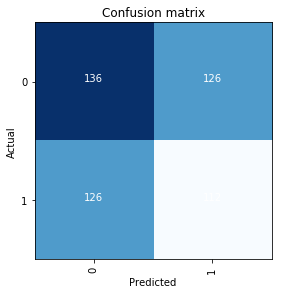

In [57]:
interpret.plot_confusion_matrix()